# How to inject and recover artifical signals from lightcurves

In addition to tools that inject artifical signals into Kepler, K2, and TESS lightcurves, `lightcurve` also includes tools to recover signals (real or injected).  In this notebook, we will recover signals of an injected supernova and an injected planet.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt

# Fitting a Supernova Signal

Let's download a TPF of a K2 galaxy and create the light curve.  We won't normalize it, because calculating the background flux is important in the fitting process.

In [2]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 

Text(0.5,1,'EPIC 220381074')

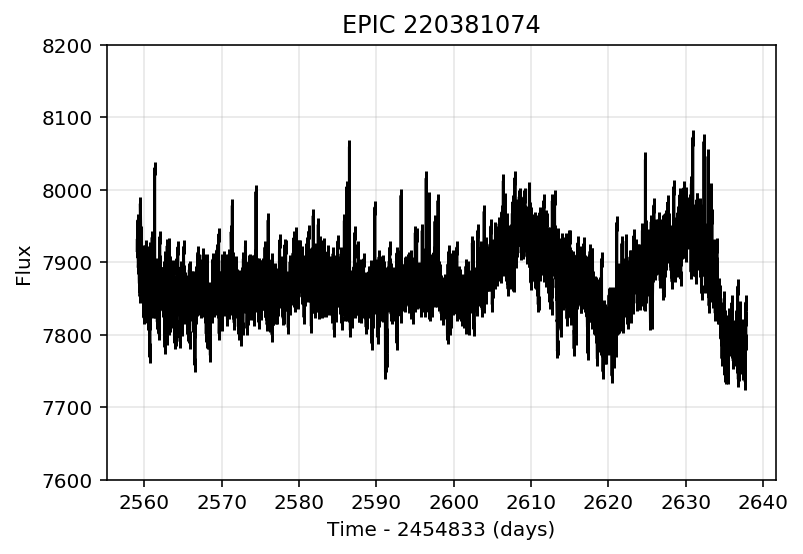

In [4]:
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

Now let's create a supernova model using `injection.SupernovaModel` class, and inject it using the `.inject` method.

This supernova will peak in the middle of the lightcurve, have a redshift of 0.5, and an amplitude of 2e-7 e/s/cm^2.

In [5]:
from lightkurve.injection import SupernovaModel
import lightkurve.injection as inj

In [6]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=8.e-8)

In [7]:
lcinj = lc.inject(model)

Let's plot the model by itself. We do this by evaluating it over the initial lightcurve's timestamps, usng the `.evaluate` method:

Text(0,0.5,'Flux')

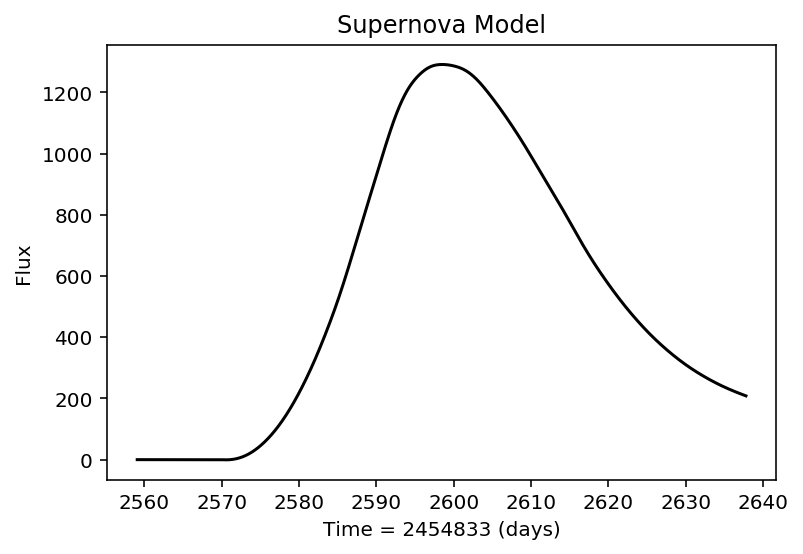

In [8]:
model_sn_eval = model.evaluate(lc.time)

plt.plot(lc.time, model_sn_eval, c='k')
plt.title('Supernova Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

And now the model injected into our galaxy:

Text(0.5,1,'EPIC 220381074 With SN')

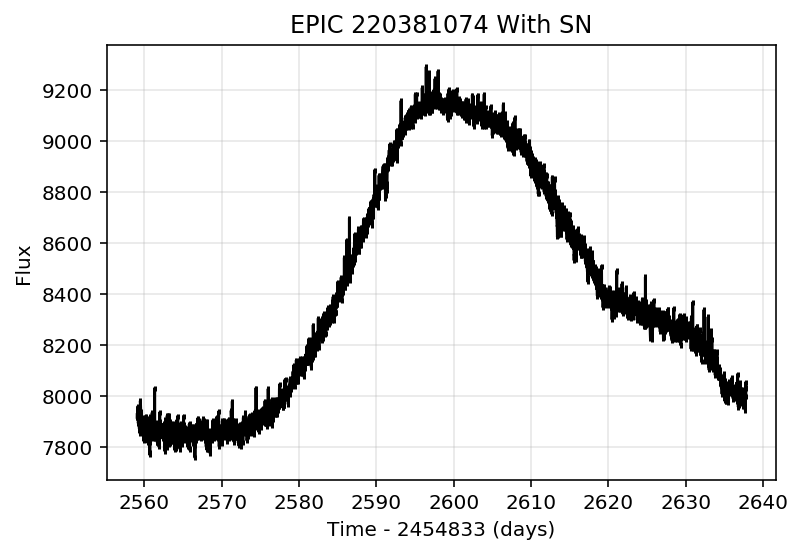

In [9]:
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')

### Now attempt to "recover" the signal through fitting methods

Fitting methods include:
    - optimization (e.g. `scipy.optimize`)
    - MCMC sampling (e.g. `emcee`)
    
The goal at the end would be to compare the **True parameters**---that is, the values that were input to make the synthetic lightcurve--- with the *recovered parameters*, the ones that we derived from our fit.  We would call the signal "sucessfully" recovered if the *recovered parameters* match the True parameters to within either:
    - A fixed tolerance level, *or*
    - A threshold of estimated uncertainty of parameters (e.g. $>1\sigma$), both within the injected signal *and* above zero by some other threshold (e.g. $>3\sigma$). 
    
So for example, let's say we inject a supernova signal with an amplitude of $a = 15.0$ photons/sec. 

If we recover a signal with $a = 14\pm 2$, we would consider that injected signal to be "recovered".  

However, if we recover a signal with $a = 16\pm 20$, we would *not* consider that injected signal to be "recovered" because the signal is consistent with *zero* supernova, despite being consistent with the injected signal.

As another example, if we recover a signal with $a = 16\pm 5$, we *would* consider that injected signal to be "recovered" because the signal is just barely above our threshold of $3\sigma$.

The recovery of $a = 27\pm 1$ would disagree with our injected signal of $a = 15$, and therefore would *not* be considered a recovery.

Let's make an initial guess to start our recovery. (Only supernova recoveries may take initial guesses; transit recoveries must not take initial guesses, as a BLS search is performed.)

In [10]:
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

In [11]:
%%time
T0_fit, z_fit, amplitude_fit, background_fit = lcinj.recover('Supernova', initial_guess=x0)

CPU times: user 16.6 s, sys: 1.37 s, total: 18 s
Wall time: 9.24 s


We can a new SupernovaModel object with the fitted parameters and overplot it with the injected lightcurve:

In [12]:
new_model = inj.SupernovaModel(T0=T0_fit, source='hsiao', bandpass='kepler', z=z_fit, amplitude=amplitude_fit)
new_fit = new_model.evaluate(lc.time) + background_fit

Text(0,0.5,'Flux')

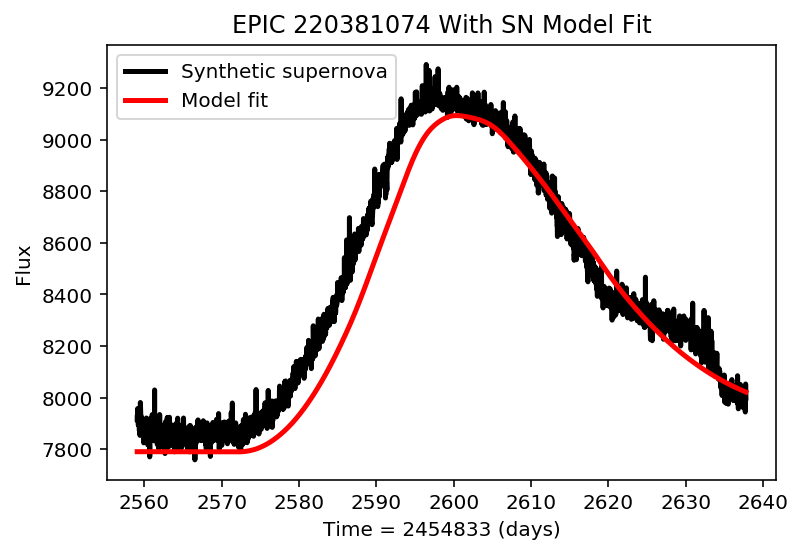

In [13]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

If we don't want to specify an initial guess, `.recover` will create a default initial guess.

In [14]:
T0_f, z_f, amplitude_f, background_f = lcinj.recover('Supernova')

In [15]:
new_model = inj.SupernovaModel(T0=T0_f, source='hsiao', bandpass='kepler', z=z_f, amplitude=amplitude_f)
new_fit = new_model.evaluate(lc.time) + background_f

Text(0,0.5,'Flux')

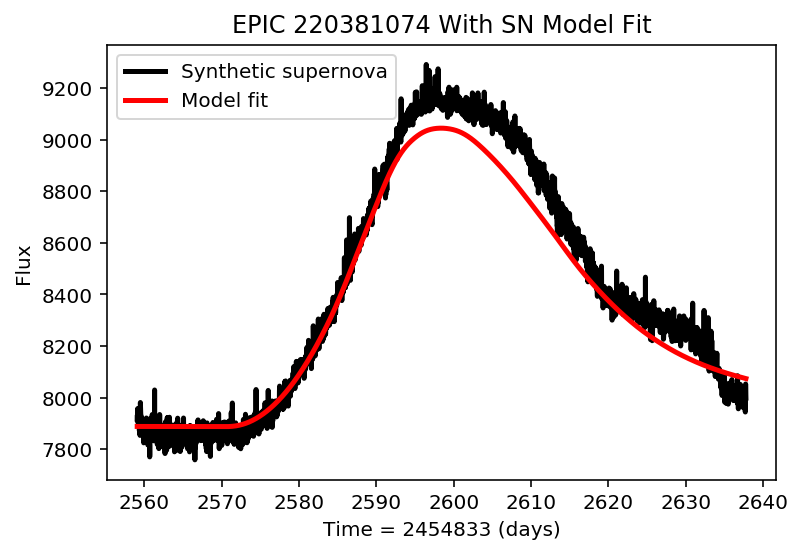

In [16]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

# Fitting a Planetary Transit

Now let's try to fit a planetary transit.  Let's download a TPF and Kepler lightcurve of a G-type star:

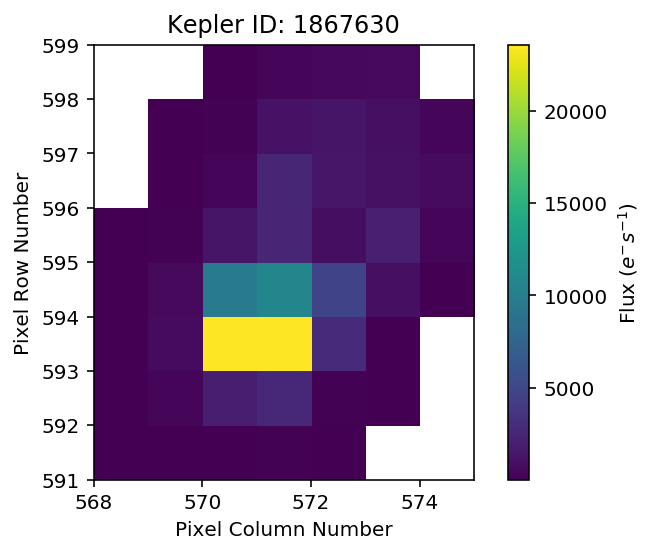

In [17]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
tpf_star.plot()

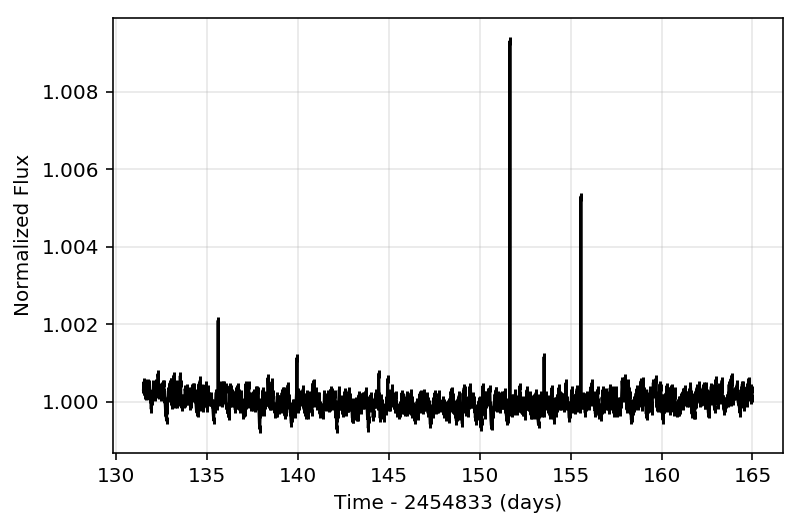

In [18]:
lc_star = tpf_star.to_lightcurve(aperture_mask='all')
lc_star.plot()

I am going to normalize this light curve, because we are multiplying in a normalized transit lightcurve.

Text(0.5,0,'Time (days)')

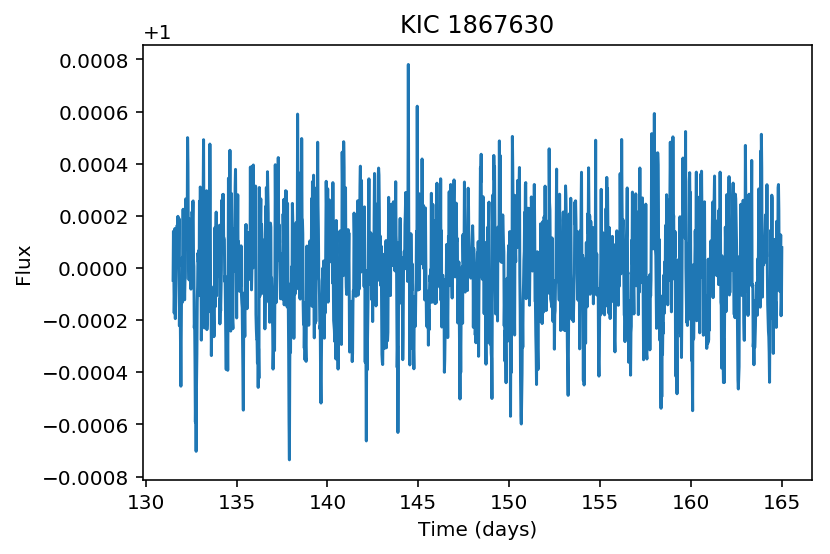

In [19]:
lc_star = lc_star.remove_nans().remove_outliers()
lc_star = lc_star.normalize().flatten()

plt.plot(lc_star.time, lc_star.flux)
plt.title('KIC 1867630')
plt.ylabel('Flux')
plt.xlabel('Time (days)')

Now I'm injecting a lightcurve of a Jupiter-sized planet with an orbital period of 5 days.

In [20]:
import batman
from lightkurve.injection import GaussianDistribution

In [21]:
model = inj.TransitModel()
model.add_planet(period=8, rprs=.07, T0=133)
lc_transit = lc_star.inject(model)

Let's plot just the model:

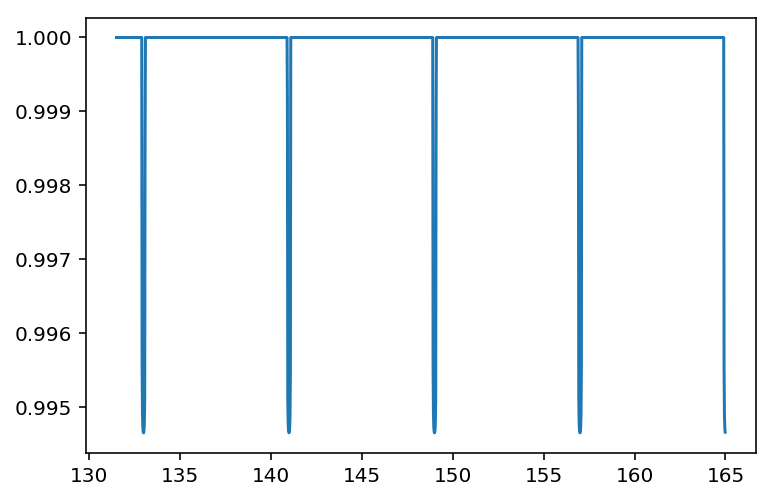

In [22]:
model_eval = model.evaluate(lc_star.time.astype(np.float))
plt.plot(lc_transit.time, model_eval)

And now the injected lightcurve:

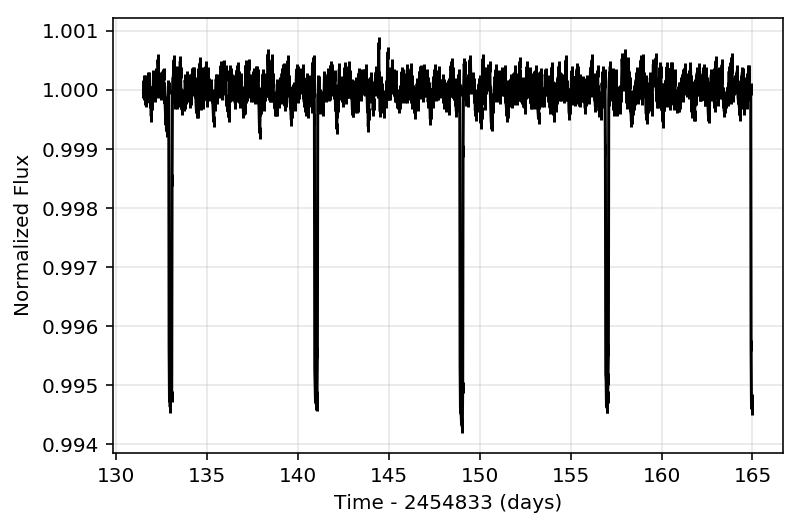

In [23]:
lc_transit.plot()

Now let's recover the transits using the `.recover` method with `signaltype = 'Planet'`.

In [24]:
%%time
period_fit, rprs_fit, T0_fit = lc_transit.recover('Planet')

CPU times: user 1.32 s, sys: 9.81 ms, total: 1.33 s
Wall time: 772 ms


In [25]:
print(period_fit, rprs_fit, T0_fit)

(7.999721342946786, 0.07004916734818935, 133.00048706230876)


Let's create a new model with these parameters and overplot with the injected signal.

In [26]:
model = inj.TransitModel()
model.add_planet(period=period_fit, T0=T0_fit, rprs=rprs_fit, a = 15, inc = 90, ecc = 0, w = 90, limb_dark = "nonlinear", u = [0.5, 0.1, 0.1, -0.1])

flux_fit = model.evaluate(lc_transit.time.astype(np.float))




Text(0,0.5,'Flux')

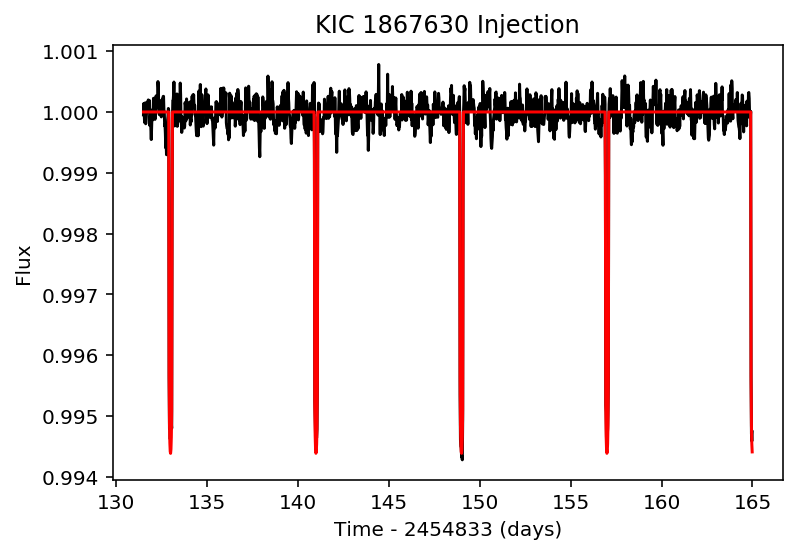

In [27]:
plt.plot(lc_transit.time, lc_transit.flux, color='k')
plt.plot(lc_transit.time, flux_fit, color='r')
plt.title('KIC 1867630 Injection')
plt.xlabel('Time - 2454833 (days)')
plt.ylabel('Flux')

# Now let's do an injection test

We can inject and recover many signals in series and determine the fraction of recovered signals.  We're going to do a transit injection and recovery test on the G-type star previously used.

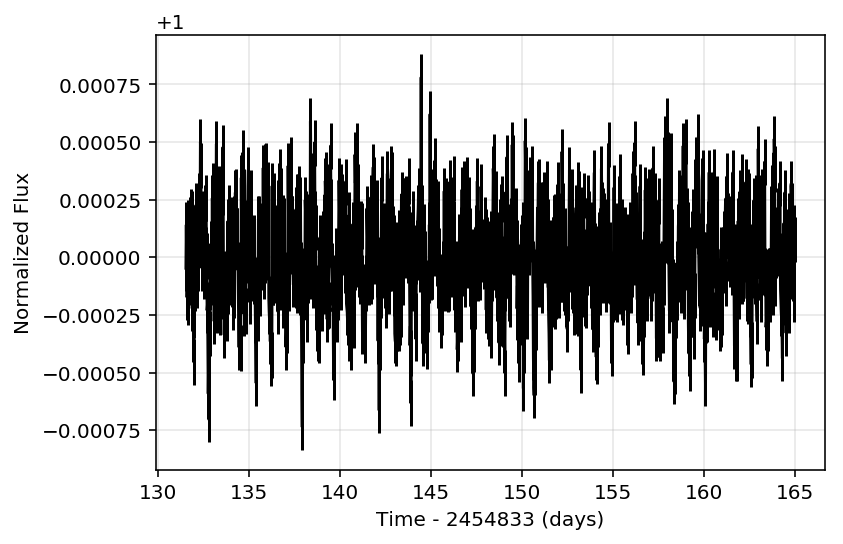

In [28]:
lc_star.plot()

We define the period, rprs, and T0 as Distribution classes.  Each injection samples parameters randomly from these classes.

In [29]:
from lightkurve.injection import GaussianDistribution, UniformDistribution

In [30]:
period = UniformDistribution(1,10)
rprs = GaussianDistribution(0.03, 0.02)
T0 = UniformDistribution(1,6)

In [36]:
frac = inj.injrec_test(lc_star, signal_type='Planet', ntests=5, constr=0.03, period=period, rprs=rprs, T0=T0)

Recovered: 3.054744077 0.0418953310441
1
Recovered: 1.43036850476 0.0356554187181
2
Recovered: 5.5819079153 0.0292532053397
3


In [32]:
print(frac)

0.5


2/3 of the planets we tested are recovered using leastsq

In [33]:
import lightkurve.injection as inj

In [34]:
%%time
sampler, x = inj.recover(lcinj.time, lcinj.flux, lcinj.flux_err, 'Supernova', method='mcmc', ndim=4, nwalkers=10, nsteps=8, initial_guess=x0)


CPU times: user 17.2 s, sys: 1.71 s, total: 18.9 s
Wall time: 9.7 s


/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


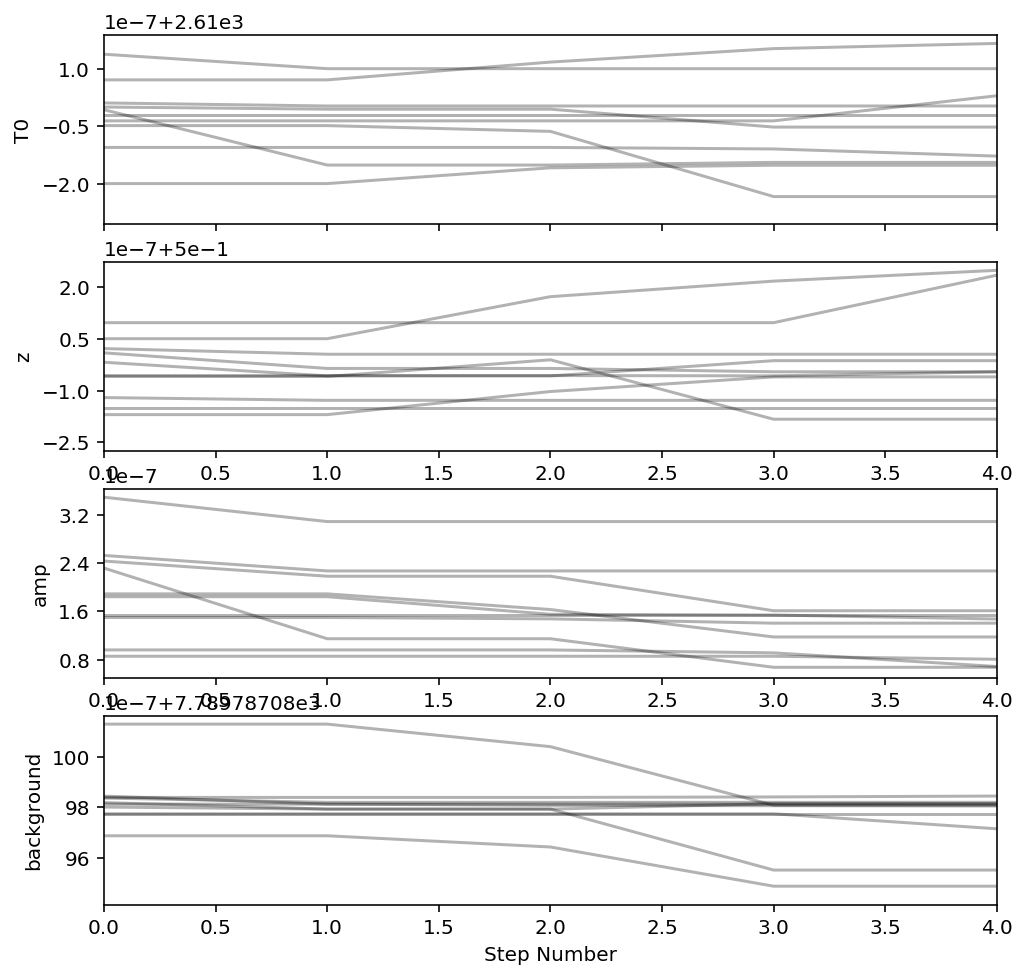

In [35]:
from matplotlib.ticker import MaxNLocator

samples = sampler.chain
labels = ['T0', 'z', 'amp', 'background']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(4, 1, i + 1)
    ax.plot(sampler.chain[:, 0:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, 4)
fig1.show()

In [38]:
%%time
sampler, x = lcinj.recover('Supernova', method='mcmc', ndim=4, nwalkers=10, nsteps=4, initial_guess=x0)



CPU times: user 9.5 s, sys: 942 ms, total: 10.4 s
Wall time: 5.37 s


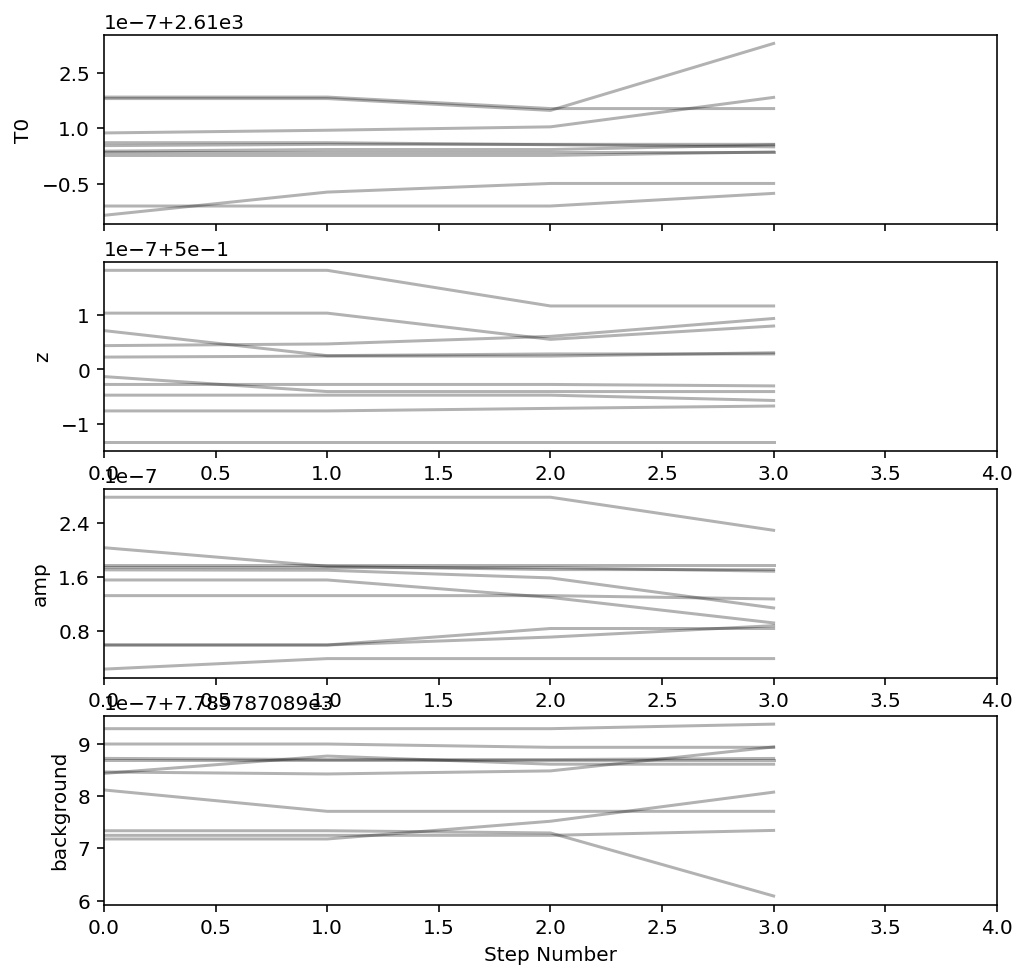

In [39]:
samples = sampler.chain
labels = ['T0', 'z', 'amp', 'background']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(4, 1, i + 1)
    ax.plot(sampler.chain[:, 0:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, 4)
fig1.show()